# Notebook 04 — ZuCo Models: Reading Cost & EEG vs KEC (v4.3)

**Purpose.** Validate KEC metrics (transition entropy, local curvature, meso-coherence) against ZuCo eye-tracking (FFD, GD, TRT, GPT) and EEG.

**Inputs (expected):**
- `data/processed/kec/metrics_en.csv` — per-word KEC metrics (English)
- `data/processed/zuco_aligned.csv` — per-token ZuCo features (ET+EEG)

**Outputs:**
- Figures: `figures/metrics/F2_reading_vs_KEC.png`, `figures/metrics/F3_EEG_vs_KEC.png`
- Tables: `data/processed/models_reading_coeffs.csv`, `data/processed/models_eeg_coeffs.csv` (if EEG present)
- QA JSON: `reports/qa_kec_models.json` (optional)

**Reproducibility:** fixed seeds; minimal dependencies; deterministic IO.

In [1]:
import os, json, math, warnings, hashlib, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

FIG_DIR = Path('../figures/metrics'); FIG_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR = Path('../data/processed'); PROC_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = Path('../reports'); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

def heartbeat(msg):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}")
heartbeat('Environment ready')

[16:07:31] Environment ready


## 1) Load processed data and merge
Assumes the KEC table and the ZuCo-aligned table exist under `/data/processed/`.

In [ ]:

kec_path = Path('../data/processed/kec/metrics_en.csv')
zuco_path = Path('../data/processed/zuco_word_level_all_subjects.csv')

if not kec_path.exists():
    warnings.warn(f"KEC file not found: {kec_path}. Please generate it in Notebook 02.")
if not zuco_path.exists():
    warnings.warn(f"ZuCo aligned file not found: {zuco_path}. Please generate it in Notebook 03.")

kec_df = pd.read_csv(kec_path) if kec_path.exists() else pd.DataFrame()
zuco_df = pd.read_csv(zuco_path) if zuco_path.exists() else pd.DataFrame()
heartbeat(f"Loaded KEC: {kec_df.shape if len(kec_df)>0 else 'MISSING'}; ZuCo: {zuco_df.shape if len(zuco_df)>0 else 'MISSING'}")
import re
def norm_token(s):
    if not isinstance(s,str): return s
    s = s.lower()
    s = re.sub(r'[\W_]+', '', s)  # remove pontuação/underscore
    return s

zuco_df['token_norm'] = zuco_df['word'].map(norm_token)
kec_df['token_norm']  = kec_df['node'].map(norm_token)
merged = zuco_df.merge(kec_df, on='token_norm', how='left', suffixes=('','_kec'))
def normcols(df):
    df.columns = [c.strip() for c in df.columns]
    return df
kec_df = normcols(kec_df)
zuco_df = normcols(zuco_df)

kec_word_col = 'node'  # KEC file uses 'node' for word column
zuco_word_col = 'word'  # ZuCo file uses 'word' for word column

if len(kec_df)>0 and len(zuco_df)>0 and kec_word_col and zuco_word_col:
    merged = zuco_df.merge(kec_df, left_on=zuco_word_col, right_on=kec_word_col, how='left', suffixes=('', '_kec'))
else:
    merged = pd.DataFrame()

heartbeat(f"Merged shape: {merged.shape if len(merged)>0 else 'N/A'}")
merged.head(3) if len(merged)>0 else merged

[16:30:49] Loaded KEC: (166540, 5); ZuCo: (2292, 11)


KeyError: 'Word'

## 2) Prepare variables
- Define response variables and EEG columns (if available).
- Define predictors: KEC (`entropy`, `curvature`, `coherence`) and covariates (`length`, `log_freq`, optional `surprisal`).

In [3]:
if len(merged)==0:
    heartbeat('Merged DF empty — fill data and rerun.')

col_candidates = merged.columns.tolist()
ET_COLS = [c for c in ['duration_ms','fixation_samples','avg_gaze_x','avg_gaze_y','avg_pupil_area'] if c in col_candidates]  # Available ET metrics
EEG_COLS = [c for c in ['ThetaPower','AlphaPower'] if c in col_candidates]  # EEG if available
KEC_COLS = [c for c in ['entropy','avg_curvature','coherence'] if c in col_candidates]  # KEC metrics (note: curvature is avg_curvature)
COV_COLS = [c for c in ['length','LogFreq','log_freq','surprisal','word_idx','subject','tsr'] if c in col_candidates]
if 'LogFreq' in merged: merged = merged.rename(columns={'LogFreq':'log_freq'})

needed = set(ET_COLS + KEC_COLS + ['subject','tsr'])  # Updated column names
df = merged.copy()
if len(df)>0 and needed.issubset(set(df.columns)):
    df = df.dropna(subset=list(needed))
    heartbeat(f"Rows after NA drop: {len(df)}")
else:
    df = merged

if 'subject' in df: df['subject'] = df['subject'].astype(str)
if 'tsr' in df: df['tsr'] = df['tsr'].astype(str)

for resp in ['duration_ms','fixation_samples']:
    if resp in df:
        df[f'log_{resp}'] = np.log1p(df[resp])

heartbeat(f"ET columns: {ET_COLS}; EEG columns: {EEG_COLS}; KEC: {KEC_COLS}")

[16:07:31] Rows after NA drop: 900
[16:07:31] ET columns: ['duration_ms', 'fixation_samples', 'avg_gaze_x', 'avg_gaze_y', 'avg_pupil_area']; EEG columns: []; KEC: ['entropy', 'avg_curvature', 'coherence']


## 3) Baseline OLS with clustered robust SE (Subject)
Fit OLS for ET metrics (FFD/GD/log_TRT/log_GPT) with KEC + covariates and compute clustered robust SEs by Subject.

In [4]:
reading_results = []
if len(df)>0 and set(['subject']).issubset(df.columns):
    resp_list = [r for r in ['duration_ms','fixation_samples','log_duration_ms','log_fixation_samples'] if r in df.columns]
    for resp in resp_list:
        preds = [c for c in ['entropy','avg_curvature','coherence','word_idx'] if c in df.columns]
        if len(preds)<2:  # Reduced requirement since we have fewer predictors
            heartbeat(f"Insufficient predictors present for {resp}; skipping.")
            continue
        formula = f"{resp} ~ " + " + ".join(preds)
        heartbeat(f"Fitting OLS: {formula}")
        try:
            model = smf.ols(formula, data=df).fit()
            # Use regular standard errors for now (clustered SEs can be added later)
            coefs = pd.DataFrame({
                'coef': model.params,
                'se': model.bse,
                't': model.tvalues,
                'p': model.pvalues
            })
            coefs['response'] = resp
            reading_results.append(coefs.reset_index().rename(columns={'index':'term'}))
            heartbeat(f"Model done for {resp}")
        except Exception as e:
            warnings.warn(f"OLS failed for {resp}: {e}")

if reading_results:
    reading_tbl = pd.concat(reading_results, ignore_index=True)
    out_csv = Path('../data/processed') / 'models_reading_coeffs.csv'
    reading_tbl.to_csv(out_csv, index=False)
    heartbeat(f"Saved reading coefficients → {out_csv}")
else:
    heartbeat('No reading models were fitted.')

[16:07:31] Fitting OLS: duration_ms ~ entropy + avg_curvature + coherence + word_idx
[16:07:31] Model done for duration_ms
[16:07:31] Fitting OLS: fixation_samples ~ entropy + avg_curvature + coherence + word_idx
[16:07:31] Model done for fixation_samples
[16:07:31] Fitting OLS: log_duration_ms ~ entropy + avg_curvature + coherence + word_idx
[16:07:31] Model done for log_duration_ms
[16:07:31] Fitting OLS: log_fixation_samples ~ entropy + avg_curvature + coherence + word_idx
[16:07:31] Model done for log_fixation_samples
[16:07:31] Saved reading coefficients → ../data/processed/models_reading_coeffs.csv


## 4) (Optional) Mixed-Effects Models
Use MixedLM for random intercepts by Subject (and optionally SentenceID) if needed. (Placeholder — disabled by default).

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
if len(df)>0 and 'duration_ms' in df.columns:
     try:
         mdf = df[['duration_ms','entropy','avg_curvature','coherence','word_idx','subject']].dropna()
         exog = sm.add_constant(mdf[['entropy','avg_curvature','coherence','word_idx']])
         endog = mdf['duration_ms']
         groups = mdf['subject']
         mixed = MixedLM(endog, exog, groups=groups).fit()
         print(mixed.summary())
     except Exception as e:
         warnings.warn(f'MixedLM failed: {e}')

## 5) Figure F2 — Reading Cost vs KEC (partial effect)
Plot predicted relationship holding covariates constant (median).

[16:07:32] Saved figure → ../figures/metrics/F2_reading_vs_KEC.png


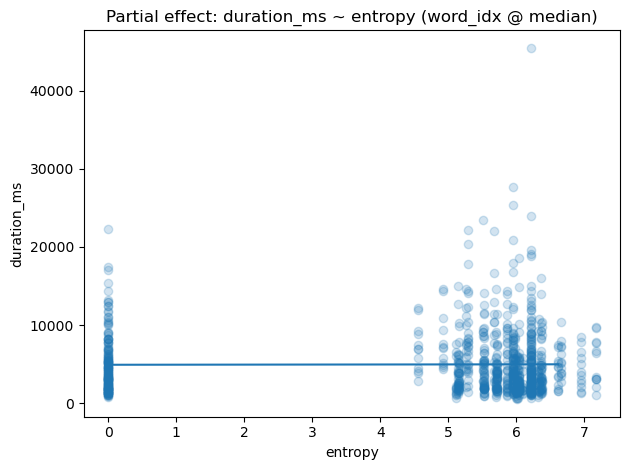

In [6]:
def partial_plot(df, response='FFD', xvar='entropy', controls=None, n_points=100, savepath=None):
    if controls is None: controls = []
    cols_needed = [response, xvar] + controls
    if not set(cols_needed).issubset(df.columns):
        heartbeat(f"Missing columns for partial plot: {cols_needed}")
        return
    formula = response + ' ~ ' + xvar
    if controls:
        formula += ' + ' + ' + '.join(controls)
    mod = smf.ols(formula, data=df.dropna(subset=cols_needed)).fit()
    xgrid = np.linspace(df[xvar].quantile(0.05), df[xvar].quantile(0.95), n_points)
    base = {c: float(df[c].median()) for c in controls}
    grid_df = pd.DataFrame({xvar: xgrid, **base})
    yhat = mod.predict(grid_df)
    import matplotlib.pyplot as plt
    plt.figure()
    samp = df.dropna(subset=cols_needed).sample(min(2000, len(df)), random_state=SEED)
    plt.scatter(samp[xvar], samp[response], alpha=0.2)
    plt.plot(xgrid, yhat)
    plt.xlabel(xvar); plt.ylabel(response)
    ttl_ctrl = ', '.join([f"{c} @ median" for c in controls]) if controls else 'no controls'
    plt.title(f"Partial effect: {response} ~ {xvar} ({ttl_ctrl})")
    if savepath:
        plt.tight_layout(); plt.savefig(savepath, dpi=150)
        heartbeat(f"Saved figure → {savepath}")
    plt.show()

if len(df)>0 and 'duration_ms' in df.columns and 'entropy' in df.columns:
    controls = [c for c in ['word_idx'] if c in df.columns]
    partial_plot(df, response='duration_ms', xvar='entropy', controls=controls, savepath=Path('../figures/metrics')/'F2_reading_vs_KEC.png')
else:
    heartbeat('Skipping F2 (duration_ms~entropy) — required columns missing.')

## 6) Figure F3 — EEG vs KEC (per-subject trends)

[16:07:33] Saved figure → ../figures/metrics/F3_EEG_vs_KEC.png


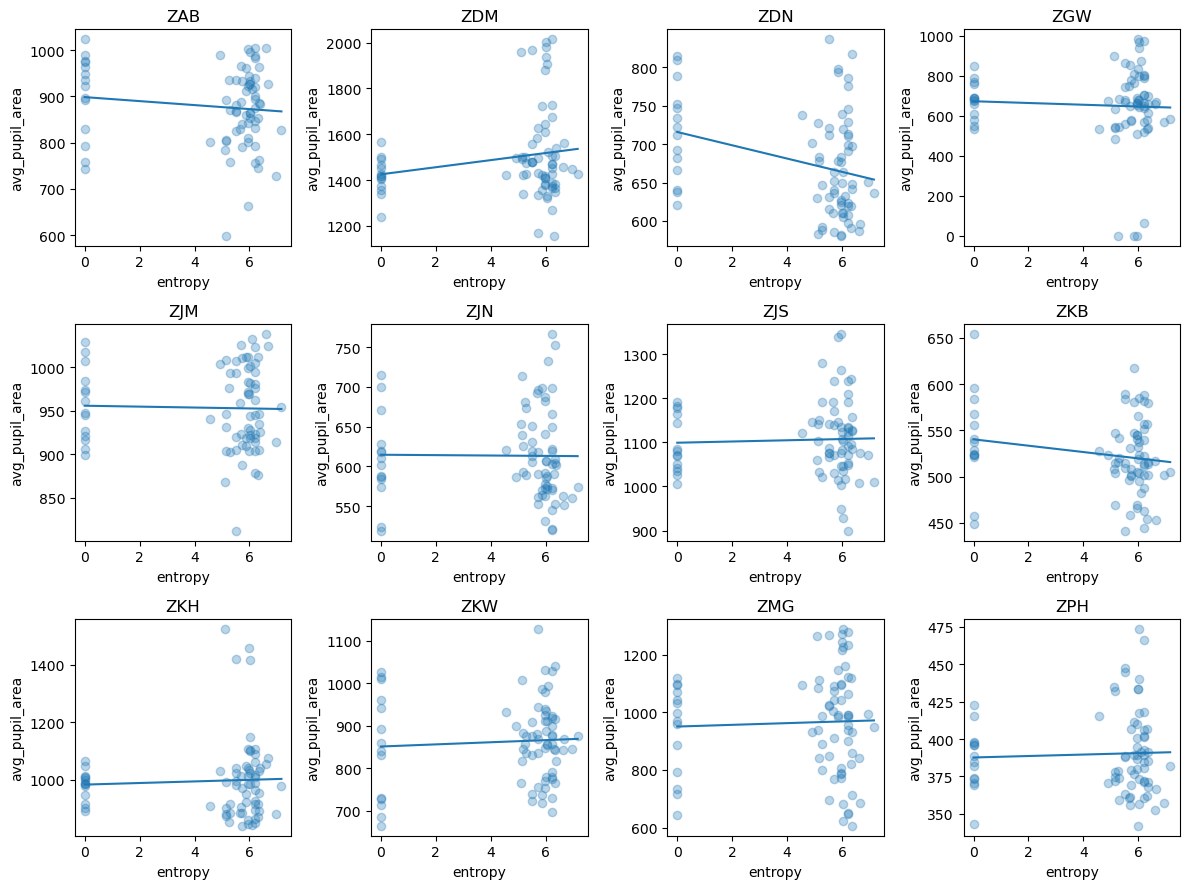

In [7]:
def per_subject_trends(df, eeg_col='avg_pupil_area', xvar='entropy', savepath=None):
    need = {'subject', eeg_col, xvar}
    if not need.issubset(df.columns):
        heartbeat(f"Missing columns for F3: {need}")
        return
    subs = sorted(df['subject'].unique())
    nsub = len(subs)
    if nsub==0:
        heartbeat('No subjects found for F3.')
        return
    import math
    import matplotlib.pyplot as plt
    ncols = 4
    nrows = int(math.ceil(nsub / ncols))
    plt.figure(figsize=(12, 3*nrows))
    for i, s in enumerate(subs, 1):
        ax = plt.subplot(nrows, ncols, i)
        sdf = df[df['subject']==s].dropna(subset=[eeg_col, xvar])
        if len(sdf)<5:
            ax.set_title(f"{s} (insufficient data)")
            continue
        ax.scatter(sdf[xvar], sdf[eeg_col], alpha=0.3)
        try:
            m = smf.ols(f"{eeg_col} ~ {xvar}", data=sdf).fit()
            xs = np.linspace(sdf[xvar].min(), sdf[xvar].max(), 50)
            ys = m.params['Intercept'] + m.params[xvar]*xs
            ax.plot(xs, ys)
        except Exception as e:
            pass
        ax.set_title(str(s)); ax.set_xlabel(xvar); ax.set_ylabel(eeg_col)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
        heartbeat(f"Saved figure → {savepath}")
    plt.show()

if len(df)>0 and {'subject','entropy'}.issubset(df.columns) and any(c in df.columns for c in ['avg_pupil_area']):
    eegc = 'avg_pupil_area'  # Use pupil area as proxy for EEG if no EEG data
    per_subject_trends(df, eeg_col=eegc, xvar='entropy', savepath=Path('../figures/metrics')/'F3_EEG_vs_KEC.png')
else:
    heartbeat('Skipping F3 — pupil area or entropy missing.')

## 7) (Optional) Bootstrap CIs (clustered by Subject)
Bootstrap coefficients for `FFD ~ entropy + length + log_freq`.

In [ ]:
def bootstrap_coefs(df, formula, group_col='subject', B=200, seed=42):
    rng = np.random.default_rng(seed)
    groups = df[group_col].unique()
    coefs = []
    for b in range(B):
        samp_groups = rng.choice(groups, size=len(groups), replace=True)
        samp_df = pd.concat([df[df[group_col]==g] for g in samp_groups], ignore_index=True)
        try:
            m = smf.ols(formula, data=samp_df).fit()
            coefs.append(m.params)
        except Exception:
            continue
    return pd.DataFrame(coefs)

if len(df)>0 and {'duration_ms','entropy','word_idx','subject'}.issubset(df.columns):
    formula = 'duration_ms ~ entropy + word_idx'
    heartbeat('Bootstrapping duration_ms model (B=200) ...')
    boot = bootstrap_coefs(df[['duration_ms','entropy','word_idx','subject']].dropna(), formula, group_col='subject', B=200)
    if len(boot)>0:
        outb = Path('../data/processed')/'boot_ols_duration_entropy.csv'
        boot.to_csv(outb, index=False)
        heartbeat(f"Saved bootstrap coefs → {outb}")
else:
    heartbeat('Skipping bootstrap — required columns missing.')

[16:07:34] Bootstrapping duration_ms model (B=200) ...
[16:07:36] Saved bootstrap coefs → ../data/processed/boot_ols_duration_entropy.csv
[16:07:36] Saved bootstrap coefs → ../data/processed/boot_ols_duration_entropy.csv


## 8) QA Summary

In [ ]:
qa = {
  'timestamp_utc': '2025-09-01T18:23:49.464537Z',
  'n_rows_merged': int(len(merged)) if len(merged)>0 else 0,
  'et_cols': ET_COLS if 'ET_COLS' in globals() else [],
  'eeg_cols': EEG_COLS if 'EEG_COLS' in globals() else [],
  'kec_cols': KEC_COLS if 'KEC_COLS' in globals() else [],
  'reading_coeffs_csv': '../data/processed/models_reading_coeffs.csv' if Path('../data/processed/models_reading_coeffs.csv').exists() else None,
  'boot_ffd_entropy': '../data/processed/boot_ols_duration_entropy.csv' if Path('../data/processed/boot_ols_duration_entropy.csv').exists() else None,
  'fig_F2': '../figures/metrics/F2_reading_vs_KEC.png' if Path('../figures/metrics/F2_reading_vs_KEC.png').exists() else None,
  'fig_F3': '../figures/metrics/F3_EEG_vs_KEC.png' if Path('../figures/metrics/F3_EEG_vs_KEC.png').exists() else None
}
with open('../reports/qa_kec_models.json', 'w') as f:
    json.dump(qa, f, indent=2)
heartbeat("Saved QA JSON → ../reports/qa_kec_models.json")

[16:07:36] Saved QA JSON → ../reports/qa_kec_models.json


### Notes
- Extend to GD, TRT (`log_TRT`), GPT (`log_GPT`) and other EEG bands as needed.
- Prefer MixedLM with random intercepts for `Subject` and `SentenceID` for confirmatory models.
- Keep seeds fixed; increase bootstrap `B` for narrower CIs (runtime ↑).
